In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - velocity_radial_profiles_dr16.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
# 
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Examine the radial trends in velocity using DR16 data.
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt

## Astropy
from astropy import units as apu
from astropy.io import fits

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier
import ast1501.linear_model

In [30]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and File Names for Gaia

In [4]:
n_bs = 100

In [5]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dr16_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [6]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [7]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
gc_R = data_low_z['R']
gc_phi = data_low_z['PHI']
gc_z = data_low_z['Z']
gc_vR = data_low_z['VR']
gc_vT = data_low_z['VT']
gc_vz = data_low_z['VZ']

# Adjust the phi velocities 
gc_phi[ np.where( (gc_phi > np.pi) ) ] -= 2*np.pi

## Set the grid parameters

In [53]:
# Radial bin range and size
R_lim = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lim = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lim = [0, np.pi/2]
phib_bin_size = np.pi/60
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2
vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy'

In [54]:
lm = ast1501.linear_model.LinearModel(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size, 
    vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy')

## Tangential Velocity

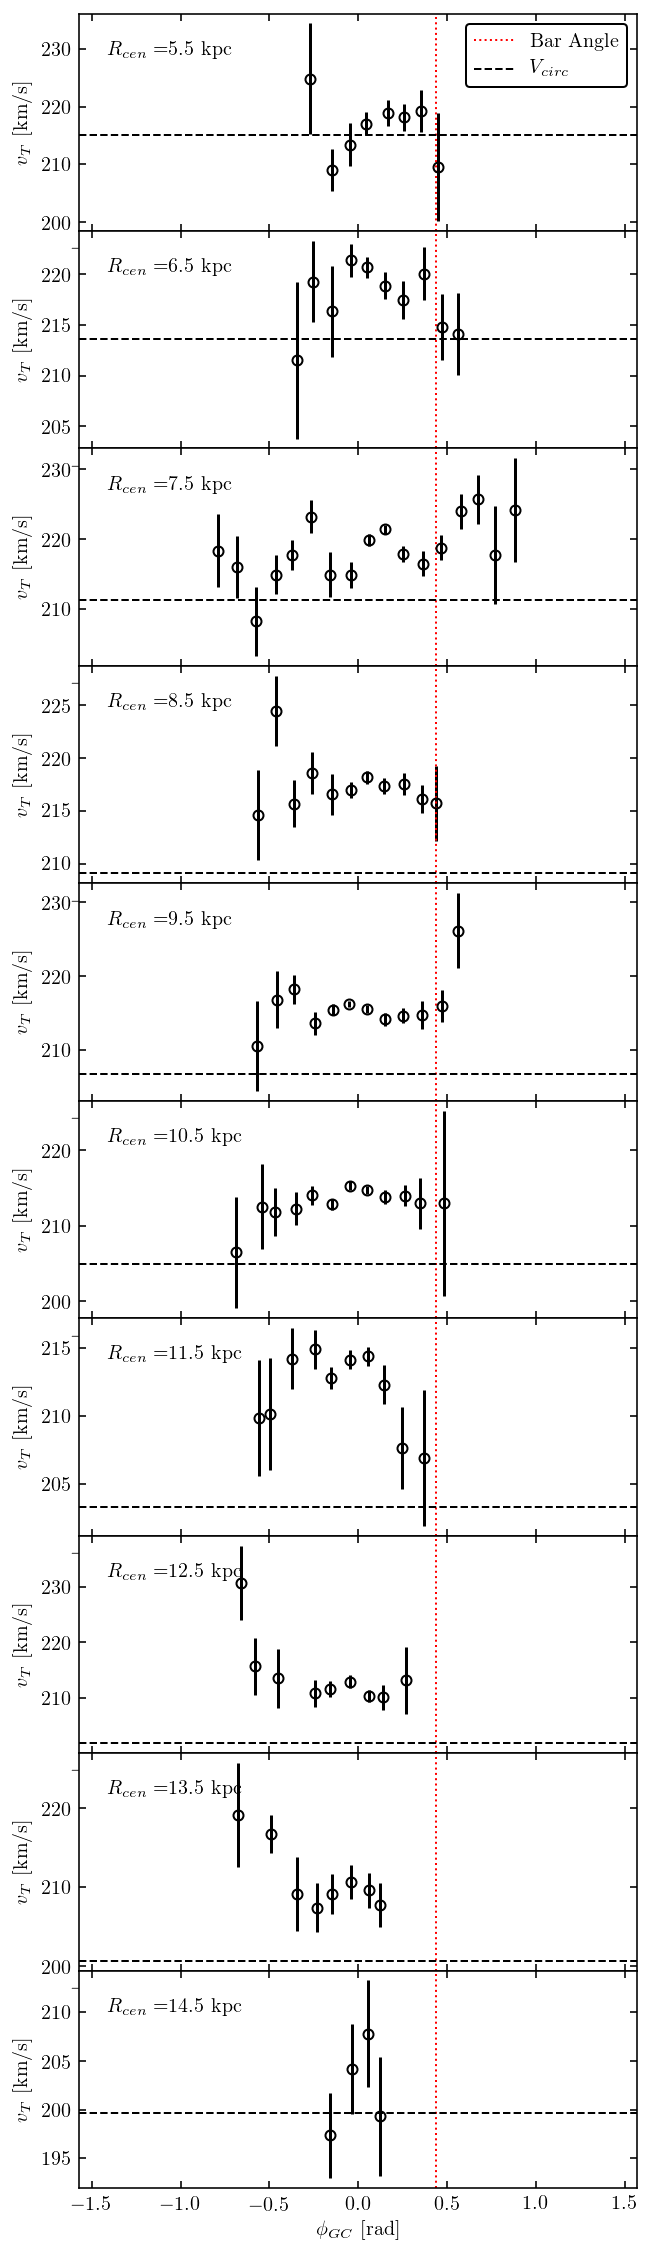

In [55]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False)
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')
plt.show()

# Radial Velocity

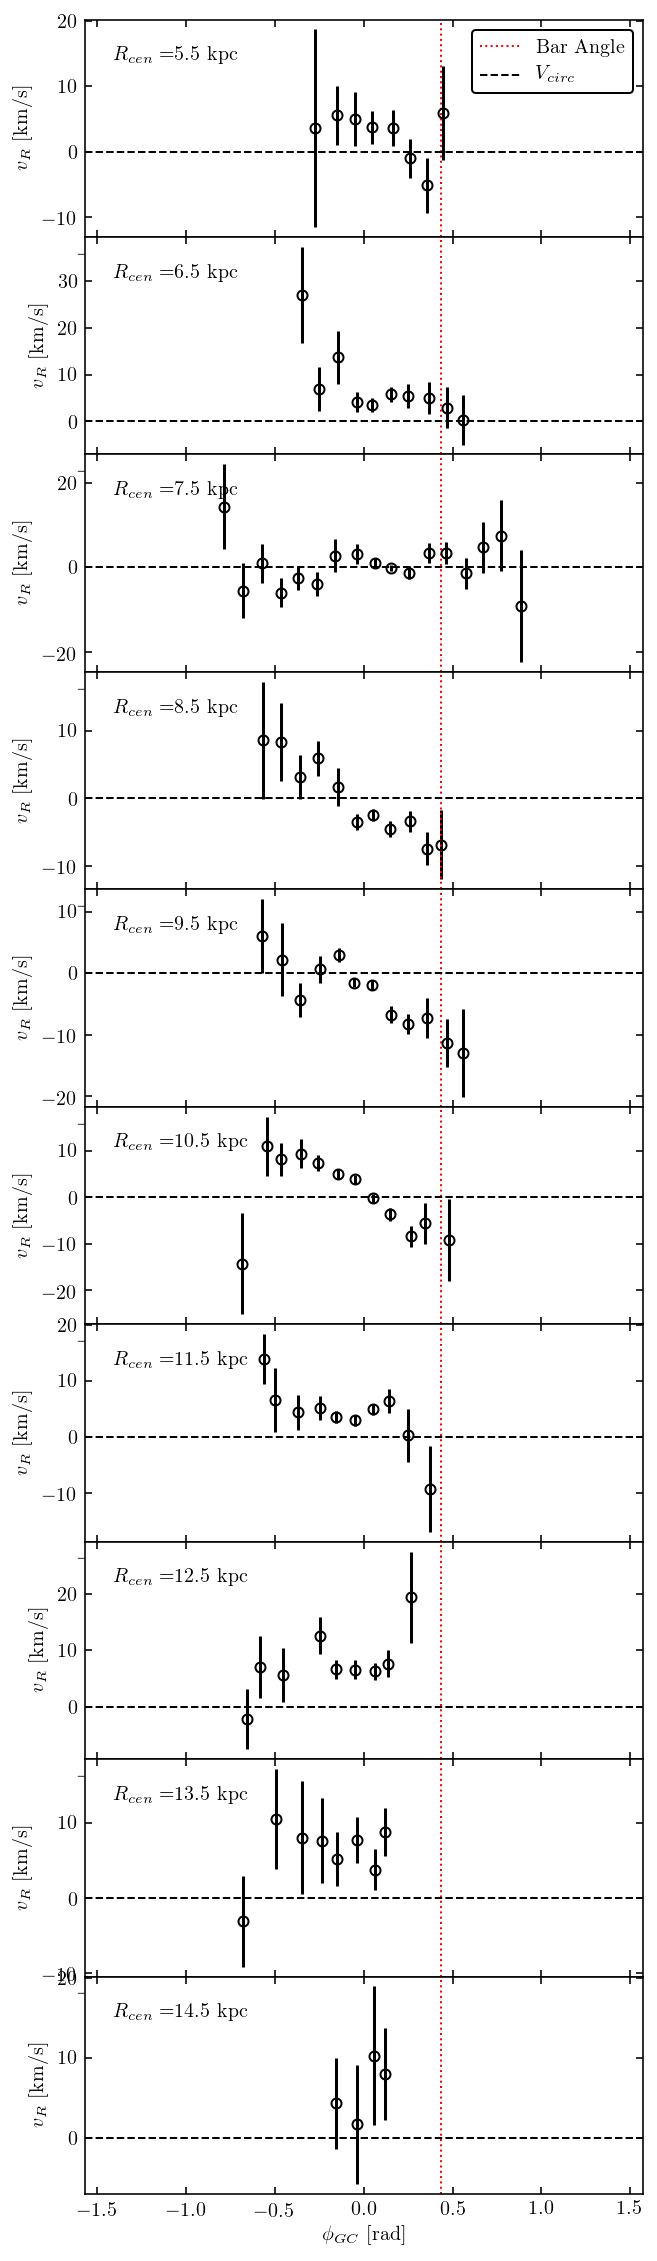

In [56]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False)
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')
plt.show()

# Include some bars

In [33]:
lm_sfb = ast1501.linear_model.LinearModel(instantiate_method=2, 
    df_filename='../../scripts/dehnen_method/bar_df/2019-05-20/data.npy', 
    phib_bin_size=phib_bin_size, phib_lims=phib_lim, 
    vT_prior_path=vT_prior_path)
lm_lsb = ast1501.linear_model.LinearModel(instantiate_method=2, 
        df_filename='../../scripts/dehnen_method/lsbar_df/2019-05-27/data.npy', 
        phib_bin_size=phib_bin_size, phib_lims=phib_lim,
        vT_prior_path=vT_prior_path)

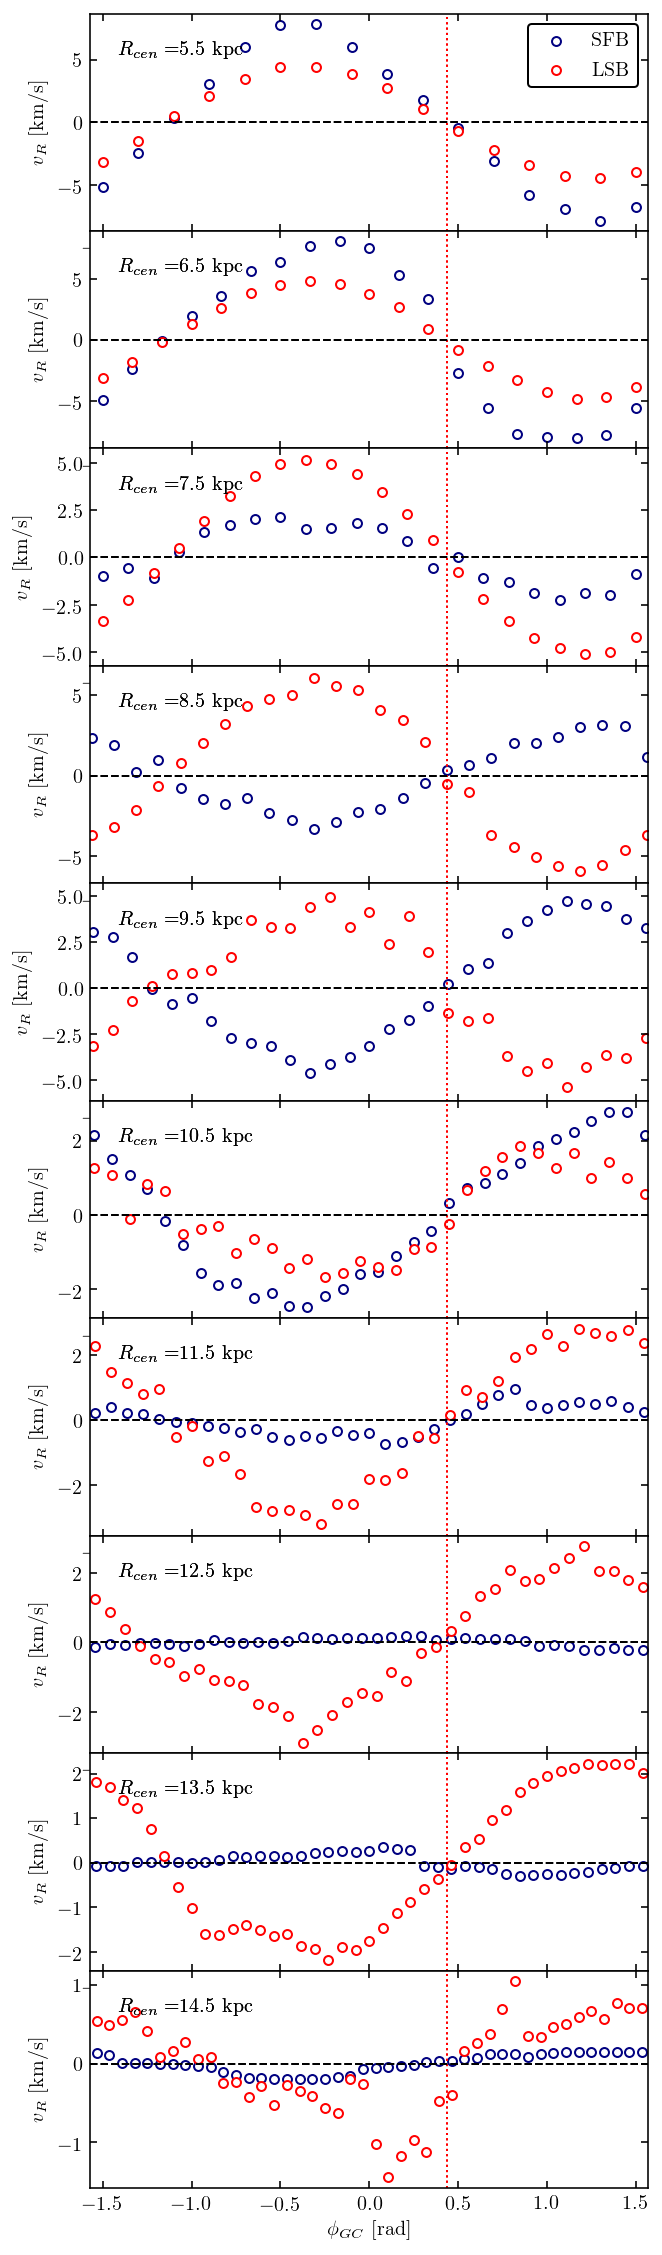

In [50]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

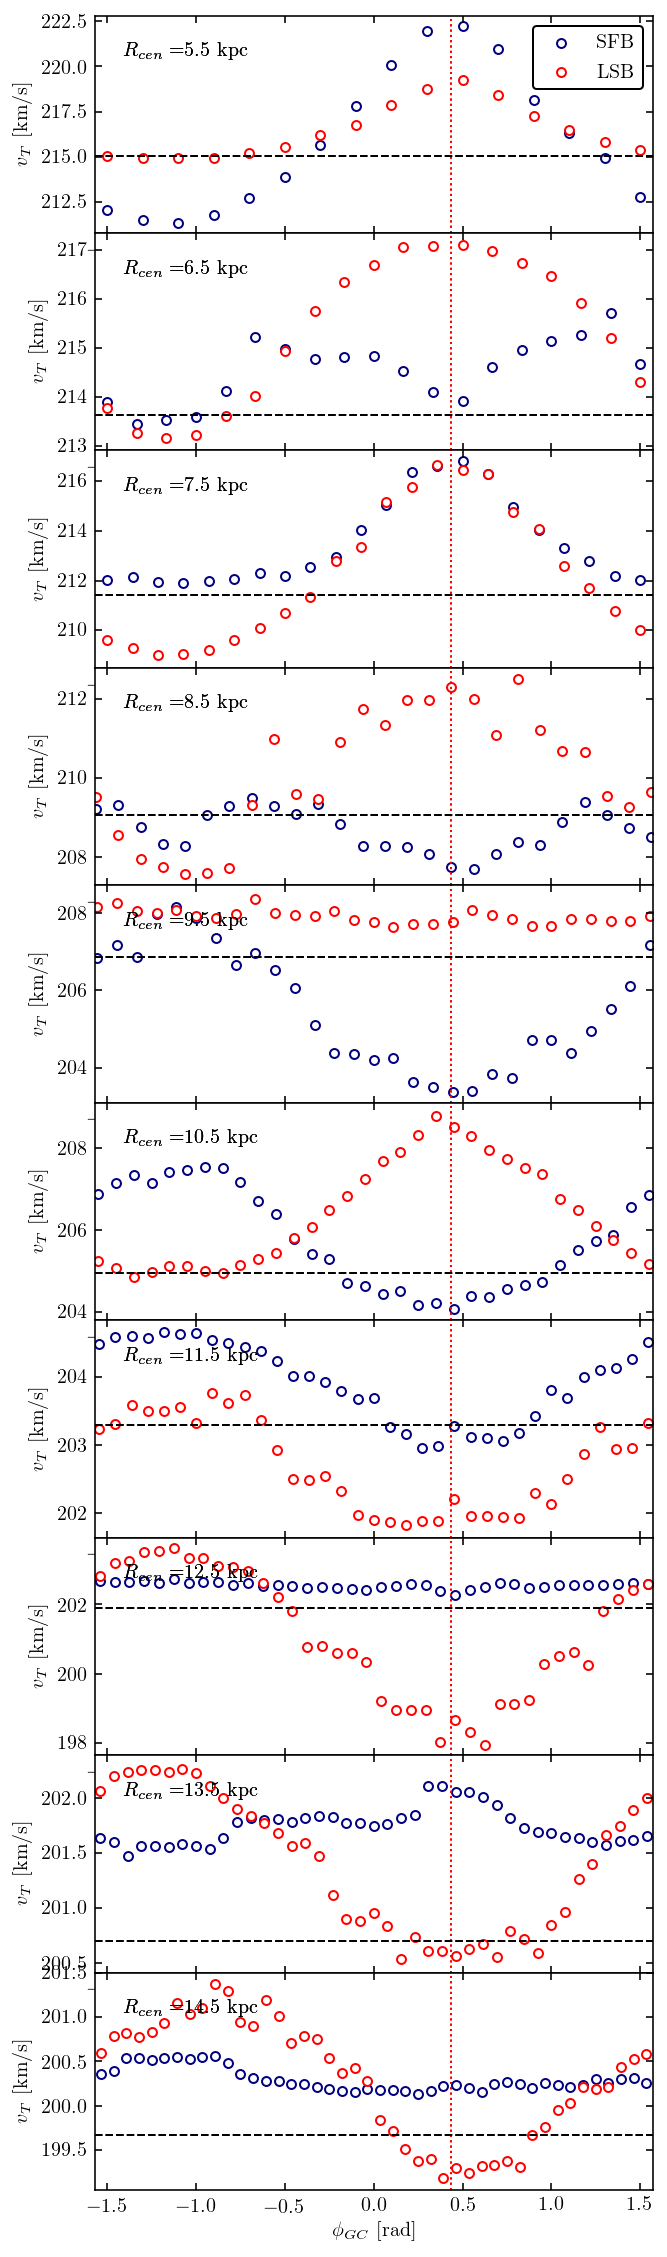

In [51]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

# Show with the data

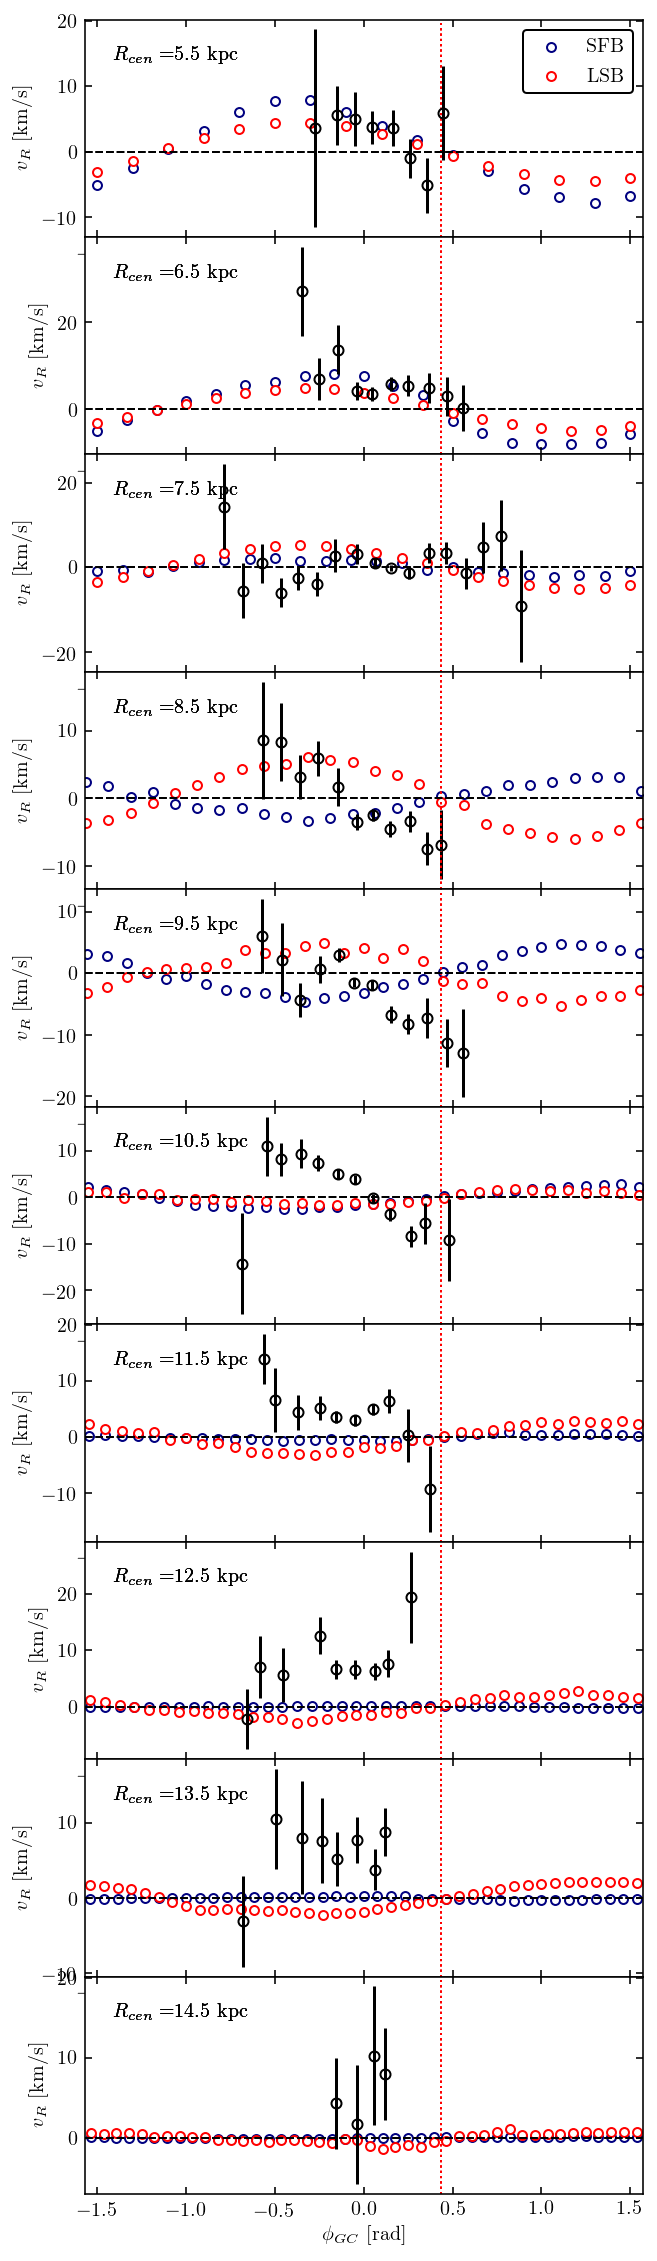

In [57]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

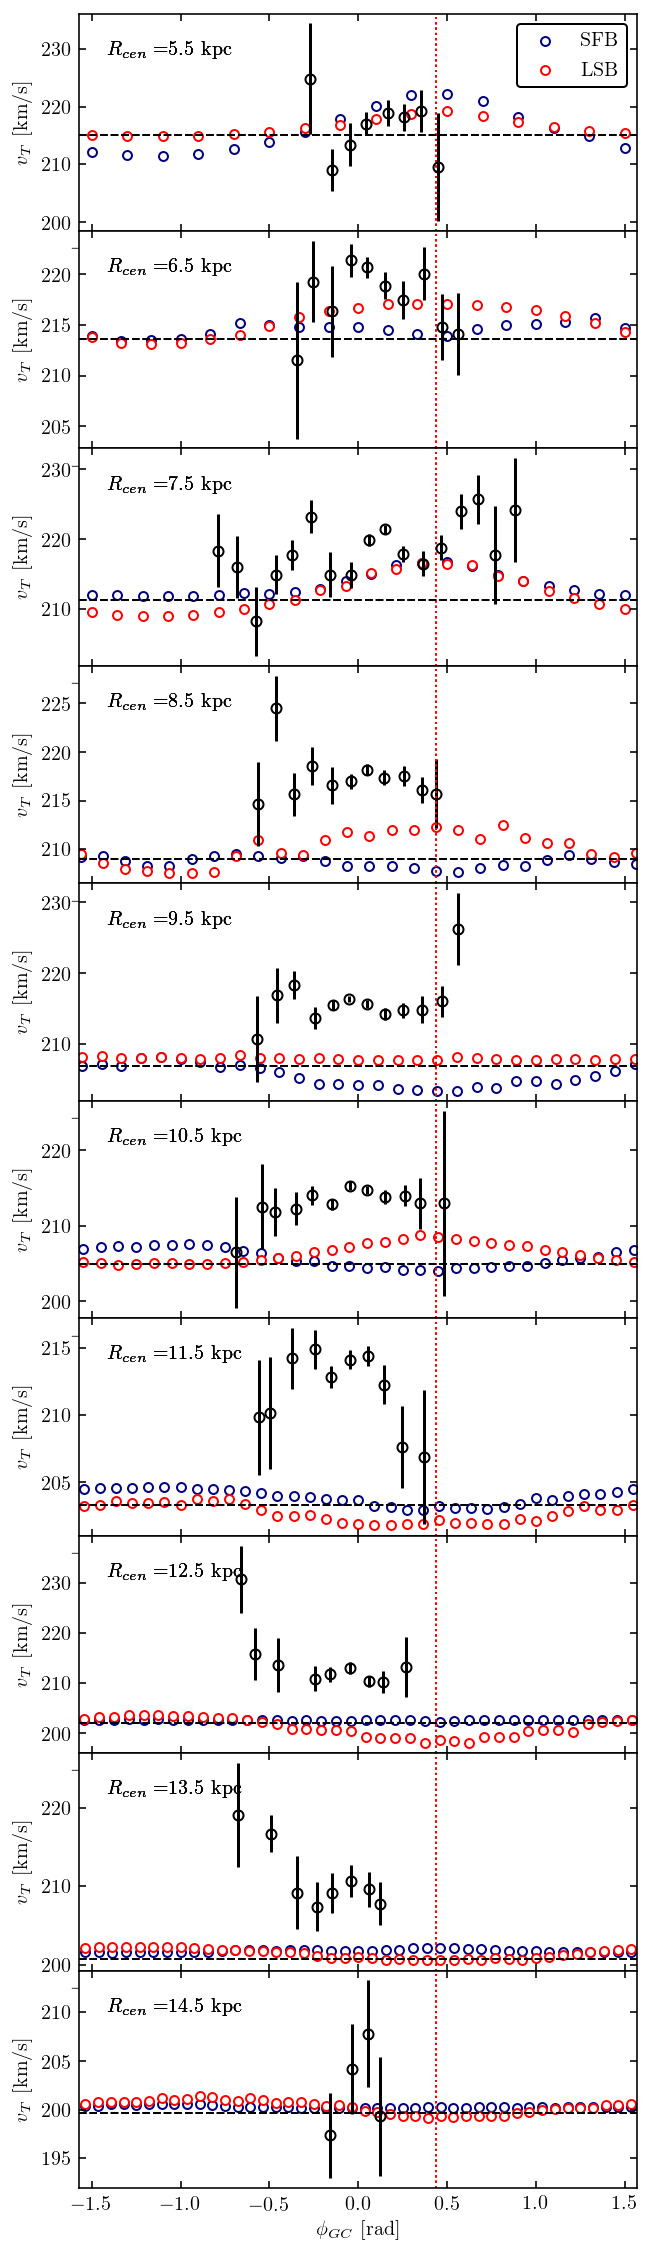

In [58]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

# Include a triaxial halo

In [61]:
lm_th = ast1501.linear_model.LinearModel(instantiate_method=2, 
        df_filename='../../scripts/dehnen_method/triaxial_df/2019-03-30/data0.npy', 
        phib_bin_size=phib_bin_size, phib_lims=phib_lim,
        vT_prior_path=vT_prior_path)

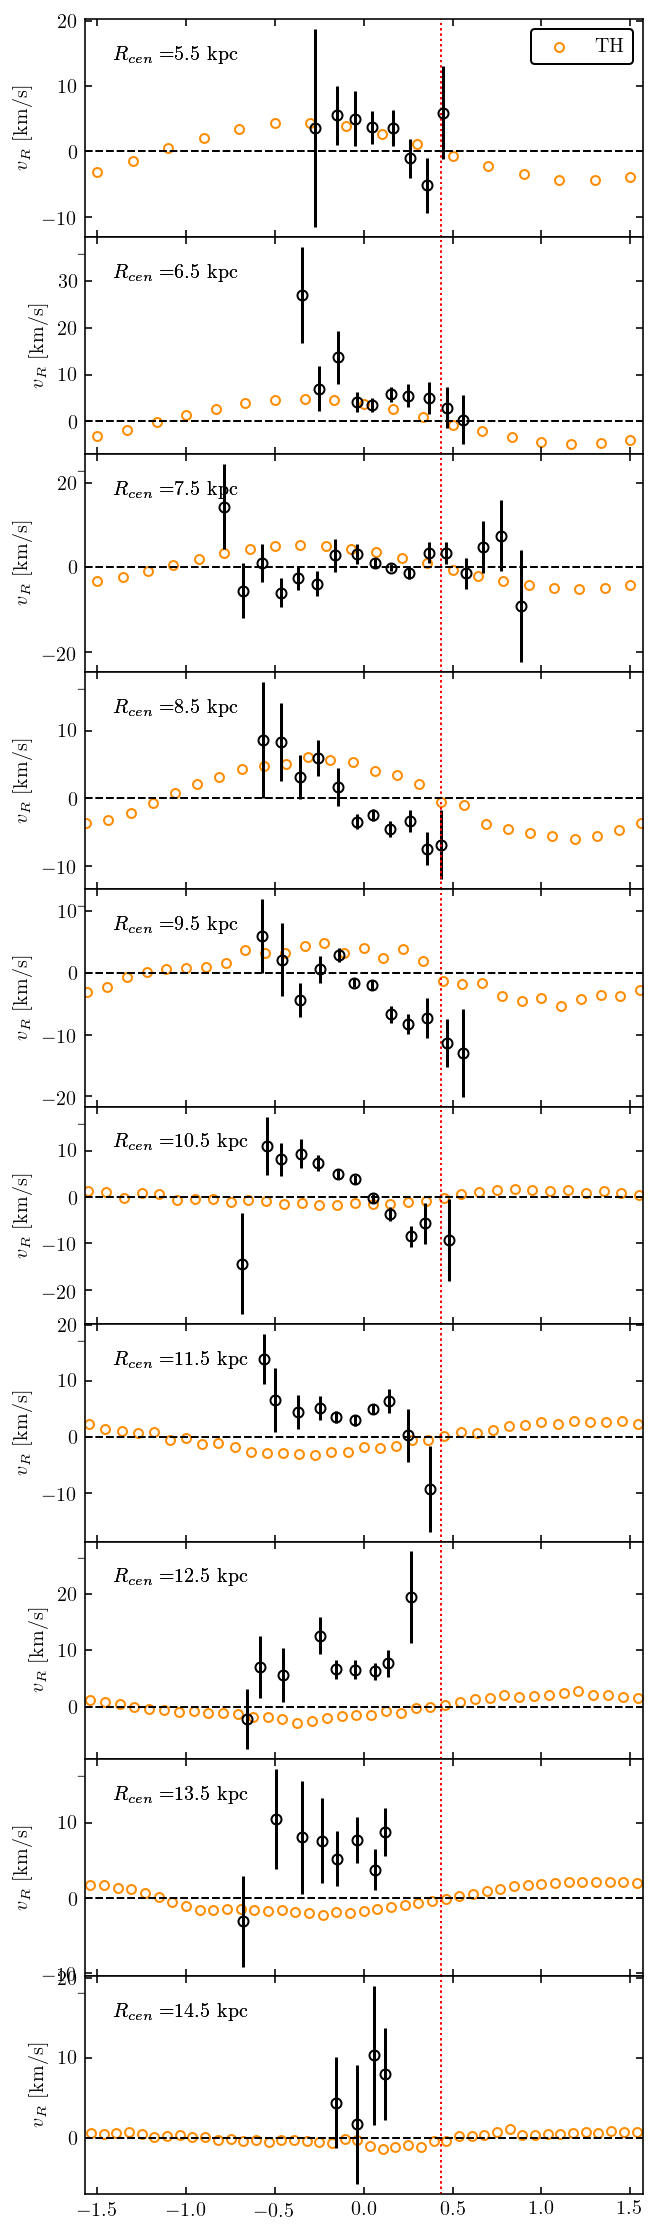

In [66]:
plot_kws_th={'facecolor':'White', 'edgecolor':'DarkOrange', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_th)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                         fig=fig, axs=axs)

fig.set_facecolor('White')
axs[0].get_legend().remove()
th_pts=axs[0].scatter([],[],**plot_kws_th)
axs[0].legend(handles=[th_pts], labels=['TH'], loc='best')